In [1]:
import pandas as pd
import basedosdados as bd
import matplotlib.pyplot as plt
import os
import numpy as np

In [202]:
%matplotlib inline

In [2]:
# Lê arquivos
def read_file(path):
    with open(path, 'r') as f:
        lines = "".join(f.read())
    return lines

In [92]:
# Locais dos arquivos queries e parquets
sim_query_path = "./Queries/sim.sql"
sim_table_path = "./Dataframes/sim.gzip"
ideb_query_path = "./Queries/ideb.sql"
ideb_table_path = "./Dataframes/ideb.gzip"
ibge_query_path = "./Queries/ibge.sql"
ibge_table_path = "./Dataframes/ibge.gzip"


dict_queries_tables = {sim_query_path:sim_table_path,
                       ideb_query_path:ideb_table_path,
                       ibge_query_path:ibge_table_path}

In [104]:
# Executa query caso já não tenha sido executada. Após executada pela primeira vez, salva o resultado em um arquivo parquet

for query_path,table_path in dict_queries_tables.items():
    if not os.path.exists(table_path):
        print("Fazendo download...")
        df = bd.read_sql(
                            read_file(query_path),
                            billing_project_id="psbd-360418")
        df.to_parquet(table_path)

sim = pd.read_parquet("./Dataframes/sim.gzip")
ideb = pd.read_parquet("./Dataframes/ideb.gzip") 
ibge = pd.read_parquet("./Dataframes/ibge.gzip") 

In [105]:
# Extrai letra e número do CID
cid = sim.causa_basica.str.extract(r"(\w)0*(\d{2})",expand=True).rename(columns={0:"letra",1:"numero"})
cid.numero = cid.numero.astype(np.int32)

# Adiciona colunas ao dataframe
sim = pd.concat([sim,cid],axis=1)

In [107]:
# Fontes: https://www.ipea.gov.br/atlasviolencia/quem/5/glossario , https://www.medicinanet.com.br/cid10/y.htm
list_mortes_violentas = [["X",85,99],
                        ["Y",0,36]]

# Encontra mortes violentas
mask_morte_violenta = sim.ano != sim.ano
for letra,min,max in list_mortes_violentas:
    mask_parcial = (sim.letra == letra) & (sim.numero >= min) & (sim.numero <= max)
    mask_morte_violenta |= mask_parcial

In [109]:
# Dataframe apenas com mortes violentas
sim_mv = sim[mask_morte_violenta].copy()

# Colunas usadas para merge entre os dataframes
colunas_merge = ["ano","id_municipio","sigla_uf"]
sim_mv = sim_mv.groupby(colunas_merge)[["numero_obitos"]].sum().reset_index()
sim_ideb = pd.merge(sim_mv,ideb[colunas_merge + ["ideb"]],on=colunas_merge,validate="one_to_one",how="outer")

In [132]:
sim_ideb_ibge = pd.merge(sim_ideb,ibge,on = colunas_merge,how="outer")

In [140]:
sim_ideb_ibge["hobitos_100k"] = 1e5 * sim_ideb_ibge["numero_obitos"] / sim_ideb_ibge["populacao"]

In [157]:
# Informações necessárias para análise
mask_analise_municipio = sim_ideb_ibge.populacao.notna() &  sim_ideb_ibge.ideb.notna() &  sim_ideb_ibge.numero_obitos.notna()
df_municipio = sim_ideb_ibge[mask_analise_municipio].reset_index(drop=True)

In [163]:
df_municipio.sort_values("populacao",ascending=False,inplace=True)

In [212]:
# Mantém apenas a primeira aparição
cum_count_uf_ano = df_municipio.groupby(["id_municipio"]).cumcount()
df_municipio = df_municipio[cum_count_uf_ano ==1].copy()

In [214]:
df_municipio.sort_values(by="ideb",inplace=True)

<AxesSubplot:xlabel='hobitos_100k'>

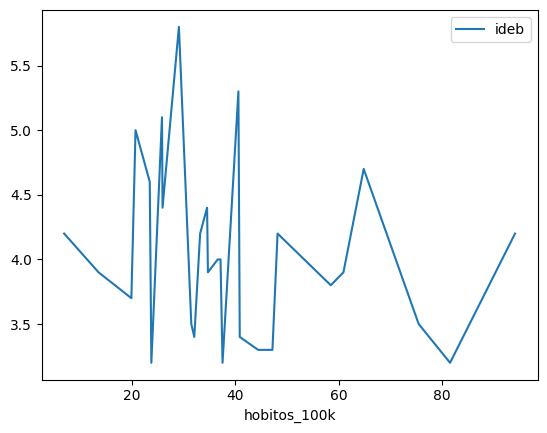

In [217]:
# Vê-se que não há correlação entre mortes e notas no IDEB
df_municipio.sort_values(by="hobitos_100k").plot("hobitos_100k","ideb")